## Use feature-weighted rf model on the crcns vim-1 dataset

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from time import time
from glob import glob
from scipy.io import loadmat
from PIL import Image
from scipy.stats import pearsonr
from hrf_fitting.src.feature_weighted_rf_models import make_rf_table,receptive_fields, model_space, prediction_menu, bigmult
from hrf_fitting.src.feature_weighted_rf_models import train_fwrf_model
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Step 0: Load crcns stimuli

#### load crcns stimuli 

In [10]:
##known stimulus parameters
Ttrn = 1750
Tval = 120
S = 500
T = Ttrn+Tval
train_stim_files = glob('/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli_Trn_FullRes*.mat')
val_stim_file = '/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli_Val_FullRes.mat'
n_image_channels = 1 ##could be 3 for color images.

In [11]:
##allocate memory for stim
training_stim = np.zeros((Ttrn,S,S),dtype='float32')

##load training stim
cnt = 0
for sl in train_stim_files:
    this_h5 = h5py.File(sl,'r')
    this_train_stim = this_h5['stimTrn']
    this_num_stim = this_train_stim.shape[-1]
    training_stim[cnt:cnt+this_num_stim,:,:] = np.transpose(this_train_stim[:],[2,1,0])
    cnt += this_num_stim
    this_h5.close()
    
##load validation stim
val_h5 = h5py.File(val_stim_file,'r')
validation_stim = np.transpose(val_h5['stimVal'][:],[2,1,0])
val_h5.close()

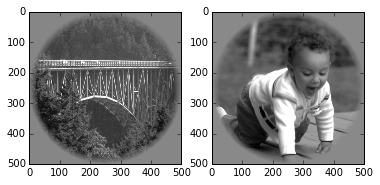

In [12]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(validation_stim[0,:,:],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(training_stim[0,:,:],cmap = 'gray')

### Step 1: construct feature maps

In [85]:
n_orientations = 2
deg_per_stimulus = 20
lowest_sp_freq = 6. ##cyc/deg
highest_sp_freq = 6.
num_sp_freq = 1
pix_per_cycle = 4 #2.13333333
complex_cell = True

print 'D = total number of features = %d' %(n_orientations * num_sp_freq)

D = total number of features = 2


#### construct gabor wavelet stack

In [86]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell)

In [87]:
gfm.gbr_table.head(num_sp_freq)

,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,6,4,0.666667,480,16,0.166667,0


In [88]:
gfm.filter_stack.shape

(2, 1, 16, 16)

#### see one of the gabors

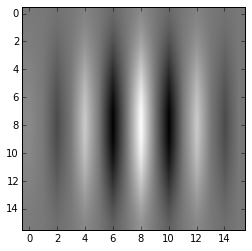

In [89]:
o = 1 ##choose an orientation
plt.imshow(np.real(gfm.filter_stack[o,0,:,:]),cmap='gray')

### Step 2: receptive fields

In [90]:
deg_per_radius = (0.5, 5, 6) ##rf sizes in degrees (smallest, largest, number of sizes)
spacing = 1. ##spacing between rf's in degrees
rf = receptive_fields(deg_per_stimulus,deg_per_radius,spacing)

In [91]:
rf.rf_table.head()

,deg_per_radius,x_deg,y_deg
0,0.5,-10.000000,-10
1,0.5,-8.947368,-10
2,0.5,-7.894737,-10
3,0.5,-6.842105,-10
4,0.5,-5.789474,-10


In [92]:
print 'G = number of rf models = %d' %(rf.rf_table.shape[0])

G = number of rf models = 2400


### Step 3: Model space

#### instantiate model space object

In [93]:
##construct a sample feature dict to initiate model space
##note that gfm expects stimuli to be 4D T x n_color_channels x S x S tensors,
##so if we want to pass just one image we need to add two singleton axes
init_feat_dict = gfm.create_feature_maps(training_stim[0,np.newaxis,np.newaxis,:,:])

allocating memory for feature maps
constructing feature maps
feature 0 took 0.021998 s.
feature 1 took 0.021504 s.


In [94]:
##construct the model space, add a bias feature (all 1's)
ms = model_space(init_feat_dict, rf, add_bias=True)

#### construct training/validation model space tensors

In [95]:
##loop over training stimuli because feature maps for all training stim. > 48Gb
training_mst = np.zeros((ms.receptive_fields.G, Ttrn, ms.D)).astype('float32')

num_chunks = 2
stim_dx = np.linspace(0,T-1,num=num_chunks+1, endpoint=True,dtype='int')

cnt = 0
for t in stim_dx[1:]:
    this_training_feature_dict = gfm.create_feature_maps(training_stim[cnt:cnt+t,np.newaxis,:,:])
    training_mst[:,cnt:cnt+t,:] = ms.construct_model_space_tensor(this_training_feature_dict,normalize=False)
    cnt += t

##clear up memory
this_training_feature_dict = []

##normalize and save normalization constants
training_mst = ms.normalize_model_space_tensor(training_mst, save=True)


##should work in one shot for because not too big
val_feature_dict = gfm.create_feature_maps(validation_stim[:,np.newaxis,:,:])
validation_mst = ms.construct_model_space_tensor(val_feature_dict)

    

allocating memory for feature maps
constructing feature maps
feature 0 took 23.351467 s.
feature 1 took 21.714949 s.
-----------feature: 0
-----------feature: 1
allocating memory for feature maps
constructing feature maps
feature 0 took 19.746738 s.
feature 1 took 18.530089 s.
-----------feature: 0
-----------feature: 1
normalization constants have been saved
model_space_tensor has been z-scored
allocating memory for feature maps
constructing feature maps
feature 0 took 3.718455 s.
feature 1 took 3.398384 s.
-----------feature: 0
-----------feature: 1
model_space_tensor has been z-scored


In [97]:
val_feature_dict[0].shape

(120, 1, 480, 480)

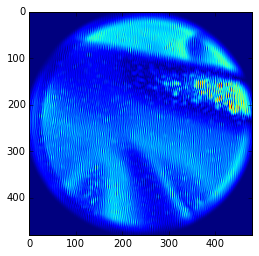

In [103]:
plt.imshow(val_feature_dict[1][-1,0,:,:])

### Step 4: load and package crcns voxel data

In [121]:
voxel_file = '/media/tnaselar/Data/crcns_datasets/vim-1/EstimatedResponses.mat'
crcns_voxel_data = h5py.File(voxel_file,'r')
crcns_voxel_data.keys()

[u'dataTrnS1',
 u'dataTrnS2',
 u'dataValS1',
 u'dataValS2',
 u'roiS1',
 u'roiS2',
 u'voxIdxS1',
 u'voxIdxS2']

#### remove nans, becuase this data-set has some. otherwise even one nan will infect gradient for every voxel.

In [122]:
voxel_data = np.concatenate((crcns_voxel_data['dataValS1'],crcns_voxel_data['dataTrnS1']),axis=0).astype('float32')
no_nan = np.isnan(voxel_data).sum(axis=0) == 0 ##<<only pulled voxels with nans in training data, should pull if nans in val data too.
voxel_data = voxel_data[:,no_nan]
print voxel_data.shape
V = voxel_data.shape[1]

(1870, 22701)


In [123]:
crcns_voxel_data.close()

#### get training/validation views on voxel_data

In [134]:
nvox=10
trnIdx = np.arange(Tval,T)
valIdx = np.arange(0,Tval)
trn_voxel_data = voxel_data[trnIdx,0:nvox]
val_voxel_data = voxel_data[valIdx,0:nvox]

### Step 4.5: Make a fake voxel

In [135]:
fake_rf = 100
fake_weights = np.random.rand(1,ms.D,1).astype('float32')
trn_voxel_data[:,0] = np.squeeze(bigmult(training_mst[np.newaxis,fake_rf,:,:],
                                   fake_weights))
val_voxel_data[:,0] = np.squeeze(bigmult(validation_mst[np.newaxis,fake_rf,:,:],
                                   fake_weights))


In [136]:
training_mst.shape

(2400, 1750, 3)

### Step 5: run that shit.

#### initialize the feature weights

In [137]:
initial_feature_weights = np.zeros((ms.receptive_fields.G,ms.D,nvox),dtype='float32')

#### train the model!

In [139]:
fvl,ffw,frf,beh = train_fwrf_model(training_mst,
                 trn_voxel_data,
                 initial_feature_weights,
                 voxel_binsize = nvox,
                 rf_grid_binsize=10,
                 learning_rate=10**(-4.9),
                 max_iters = 50,
                 early_stop_fraction=0.2,
                 report_every = 25)

--------------voxels from 0 to 8
--------candiate rf models 0 to 10
-------
errors: 341.377265
change in best rf: 41.000000
norm of feature weights: 0.049379
improvements: 99
0.00893497467041
-------
errors: 334.750487
change in best rf: 0.000000
norm of feature weights: 0.668276
improvements: 39
0.214011907578
--------candiate rf models 10 to 20
-------
errors: 341.134430
change in best rf: 56.000000
norm of feature weights: 0.044739
improvements: 99
0.00822687149048
-------
errors: 332.564184
change in best rf: 0.000000
norm of feature weights: 0.595967
improvements: 41
0.201642036438
--------candiate rf models 20 to 30
-------
errors: 341.157837
change in best rf: 42.000000
norm of feature weights: 0.051251
improvements: 99
0.00827097892761
-------
errors: 332.760591
change in best rf: -2.000000
norm of feature weights: 0.696872
improvements: 32
0.210786104202
--------candiate rf models 30 to 40
-------
errors: 340.901569
change in best rf: 51.000000
norm of feature weights: 0.04638

#### loss histories, all voxels

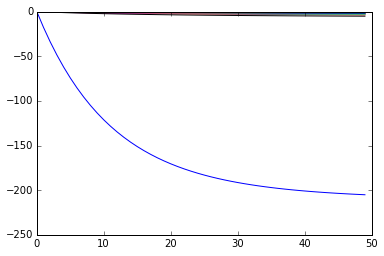

In [140]:
_=plt.plot(beh-beh[0,:])


#### view loss history for a few voxels

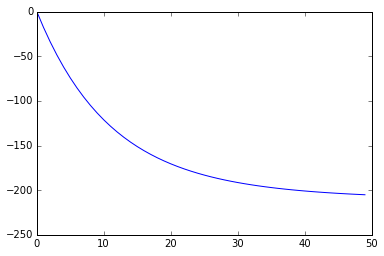

In [141]:
_=plt.plot(beh[:,slice(0,-1,200)]-beh[0,slice(0,-1,200)])

In [ ]:
##loss in "final_validation_loss" = last point of "best_error_history"
print np.min(beh[:,-2])
print fvl[-2]

#### diff between first and last point of loss history, all voxels

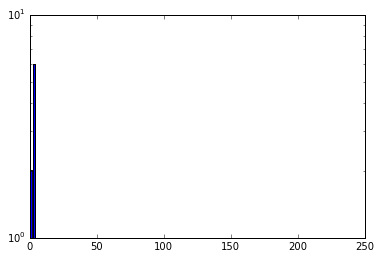

In [142]:
_=plt.hist(beh[0,:]-np.min(beh,axis=0),100)
plt.yscale('log')

### Step 6: model analysis and validation

#### histogram of rf models selected for each voxel

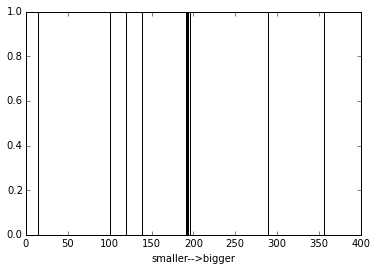

In [143]:
_=plt.hist(frf,ms.receptive_fields.G)
plt.xlabel('smaller-->bigger')

#### sum of all selected rfs. 

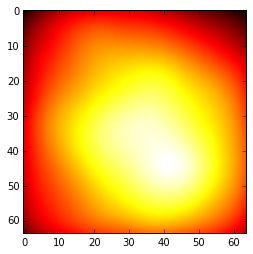

In [43]:
plt.imshow(np.sum(ms.receptive_fields.make_rf_stack(64, min_pix_per_radius=1)[frf,:,:], axis=0), cmap='hot')

#### prediction accuracy for all voxels

In [144]:
##generate predictions
# pred = prediction_menu(val_mst, ffw[np.newaxis,:,:], rf_indices = frf) ##<<too big, choked. 


##generate predictions one voxel at a time
pred = np.zeros((Tval,nvox))
for v in range(nvox-1):  ##<<some kind of bug in training function, last voxel getting skipped.
    pred[:,v] = np.squeeze(bigmult(validation_mst[np.newaxis,frf[v],:,:],
                                   ffw[np.newaxis,:,v, np.newaxis]))

In [145]:
##get correlation = prediction accuracy
val_cc = []  
for v in range(nvox-1): 
    cc = pearsonr(val_voxel_data[:,v],pred[:,v])
    if not np.isnan(cc[0]):
        val_cc.append(cc[0])

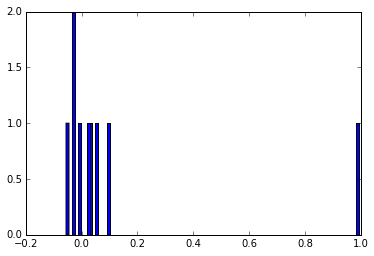

In [146]:
##histogram of prediction accuracy, all voxels
_=plt.hist(val_cc,100)
# plt.yscale('log')